In [214]:
import numpy as np
import matplotlib.pylab as plt
import pickle
import json
import new_files
import pandas as pd
import nibabel as nb
from os import sep
from copy import deepcopy
from scipy.interpolate import interp1d
from matplotlib import colors
import matplotlib.pylab as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib import colors
import trimesh
import open3d as o3d
from tools import compute_rel_power, get_crossover, detect_crossing_points, data_to_rgb
from sklearn.preprocessing import minmax_scale
from joblib import Parallel, delayed
from tqdm.notebook import tqdm_notebook

In [322]:
def csd_smooth(csd, layers=11, kind="cubic"):
    layers, time = csd.shape
    smoothed = []
    x = np.linspace(0, 1, num=layers)
    xs = np.linspace(0, 1, num=500)
    for t in range(time):
        fx = interp1d(x, csd[:, t], kind=kind)
        ys = fx(xs)
        smoothed.append(ys)
    smoothed = np.array(smoothed).T
    return smoothed


def plot_spaced_signal(signal, times, ax):
    v_contacts = signal.shape[0]
    cm = plt.colormaps["rainbow"]
    cm_l = cm(np.linspace(0,1, num=v_contacts))[:,:3]
    max_amp = np.abs(signal).max()
    max_amp = max_amp + max_amp*0.05
    spacing = np.linspace(0, max_amp * v_contacts, num=v_contacts)
    vis_signal = signal + spacing.reshape(-1,1)
    for ix, vs in enumerate(vis_signal):
        ax.plot(times, vs, lw=1, c=cm_l[ix])
    ax.set_yticks(spacing)
    ax.set_yticklabels(np.arange(1,v_contacts+1)[::-1])
    ax.set_ylim(spacing[0] - max_amp, spacing[-1] + max_amp)


def plot_csd(smooth_csd, list_ROI_vertices, bb_path, times, ax, cb=True, cmap="RdBu_r", vmin_vmax=None, return_details=False):
    layer_labels = ["I", "II", "III", "IV", "V", "VI"]
    with open(bb_path, "r") as fp:
        bb = json.load(fp)
    bb = [np.array(bb[i])[list_ROI_vertices] for i in bb.keys()]
    bb_mean = [np.mean(i) for i in bb]
    bb_std = [np.std(i) for i in bb]
    max_smooth = np.max(np.abs(smooth_csd))
    if vmin_vmax == None:
        divnorm = colors.TwoSlopeNorm(vmin=-max_smooth, vcenter=0, vmax=max_smooth)
    elif vmin_vmax == "norm":
        divnorm = colors.Normalize()
    else:
        divnorm = colors.TwoSlopeNorm(vmin=vmin_vmax[0], vcenter=0, vmax=vmin_vmax[1])
    extent = [times[0], times[-1], 1, 0]
    csd_imshow = ax.imshow(
        smooth_csd, norm=divnorm, origin="lower",
        aspect="auto", extent=extent,
        cmap=cmap, interpolation="none"
    )
    ax.set_ylim(1,0)
    ax.set_yticks(np.linspace(0,1, num=info["layers"]))
    ax.set_yticklabels(np.arange(1,12))
    layers_params = []
    for l_ix, th in enumerate(np.cumsum(bb_mean)):
        ax.axhline(th, linestyle=(0, (5,5)), c="black", lw=0.5)
        # ax.axhspan(th-bb_std[l_ix], th+bb_std[l_ix], alpha=0.05, color="black", lw=0)
        ax.annotate(layer_labels[l_ix],[times[0]+0.06, th-0.01], size=15, ha='left')
        layers_params.append([th, layer_labels[l_ix]])
    if cb:
        plt.colorbar(csd_imshow, ax=ax)
    plt.tight_layout()
    if return_details:
        return layers_params, csd_imshow


def plot_vertex_results(vx, layer_power, info, freqs, smooth_power, crossover, ab_pow, g_pow):
    f, ax = plt.subplots(1,3, figsize=(12,3))
    cm = plt.colormaps["rainbow"]
    cm_l = cm(np.linspace(0,1, num=info["layers"]))[:,:3]
    for ix in range(info["layers"]):
        ax[0].plot(freqs, layer_power[ix], c=cm_l[ix], lw=0.5)
    ax[0].set_title("PSD per layer - offset")
    ax[0].axvline(7, lw=0.5, c="black")
    ax[0].axvline(30, lw=0.5, c="black")
    ax[0].axvline(50, lw=0.5, c="black")
    ax[1].set_title("Relative PSD per layer")
    layer_deets = plot_csd(
        smooth_power, [vx],
        info["big_brain_layers_path"], 
        freqs, ax=ax[1], cmap="YlGnBu",
        vmin_vmax="norm", cb=False, return_details=True
    )
    yl=ax[1].get_ylim()
    ax[1].plot([7,7], yl,':', lw=1.5, c="white")
    ax[1].plot([30,30], yl,':', lw=1.5, c="white")
    ax[1].plot([50,50], yl,':', lw=1.5, c="white")
    ax[1].axhline(crossover/smooth_power.shape[0], linestyle=(0, (5,5)), c="red", lw=1)


    ax[2].set_title("Crossover")
    ax[2].plot(
        ab_pow, np.linspace(0, 1, smooth_power.shape[0]), label='alpha-beta', c="green"
    )
    ax[2].plot(
        g_pow, np.linspace(0, 1, smooth_power.shape[0]), label='gamma', c="blue"
    )

    ax[2].set_ylim(1, 0)
    ax[2].set_xlim(0, 1)
    ax[2].set_yticks(np.linspace(0,1, num=11))
    ax[2].set_yticklabels(np.arange(1,12));
    for th, lab in layer_deets[0]:
        ax[2].axhline(th, linestyle=(0, (5,5)), c="black", lw=0.5)
        ax[2].annotate(lab,[0.01, th-0.01],size=15)
    ax[2].axhline(crossover/smooth_power.shape[0], linestyle=(0, (5,5)), c="red", lw=1, label="Crossover")
    handles = [
        Line2D([], [], color="blue", label="Gamma"),
        Line2D([], [], color="green", label="Alpha-beta"),
        Line2D([], [], color="red", linestyle="dashed", label="Crossover")
    ]
    ax[2].legend(handles=handles, loc=8, frameon=True, fontsize="xx-small")
    ax[2].set_xlabel("Relative Power")
    return ax


def custom_draw_geometry(mesh, filename="render.png", visible=True, wh=[960, 960], save=True):
    vis = o3d.visualization.Visualizer()
    vis.create_window(width=wh[0], height=wh[1], visible=visible)
    if isinstance(mesh, list):
        for i in mesh:
            vis.add_geometry(i)
    else:
        vis.add_geometry(mesh)
    vis.get_render_option().mesh_show_back_face=True
    vis.get_render_option().light_on=True
    vis.run()
    if save:
        vis.capture_screen_image(filename, do_render=True)
    vis.destroy_window()

In [2]:
dir_search = new_files.Files()

In [26]:
dataset_path = "/home/common/bonaiuto/multiburst/derivatives/processed/"

In [27]:
all_psd_wholebrain = dir_search.get_files(
    dataset_path,
    "*.npy", prefix="PSD_"
)
all_psd_wholebrain.sort()
dict_epoch = {i: [j for j in all_psd_wholebrain if i in j] for i in ["motor", "visual"]}

In [28]:
all_info = dir_search.get_files(
    dataset_path,
    "*.json", prefix="info"
)

In [360]:
data_file = dict_epoch["motor"][0]
data = np.load(data_file)
core_path = sep.join(data_file.split(sep)[:-1]) + sep
core_name = data_file.split(sep)[-1].split("_")[-1].split(".")[0]
subject = "-".join(core_name.split("-")[1:3])
info_file = [i for i in all_info if subject in i][0]
with open(info_file) as pipeline_file:
    info = json.load(pipeline_file)

data = np.array(np.split(data, 11, axis=0)) # layer x vertex x freqs
flims = [0.1,125]
freqs = np.linspace(*flims, data.shape[2])
vx_no = data.shape[1]

-0.9999999999999998
-1.0


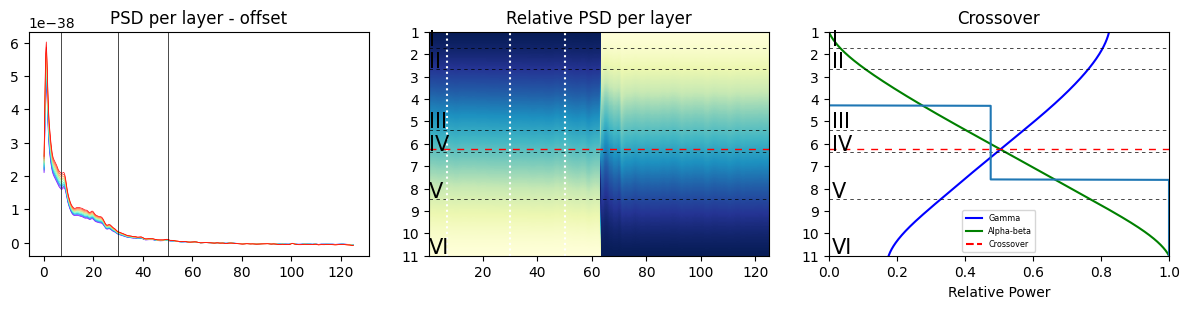

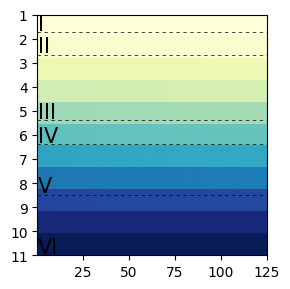

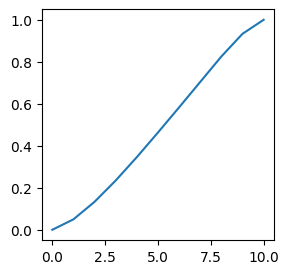

In [365]:
# visualise the vertex
vx = 4000 #1000 vs 4000, weird: 3000
layer_power = data[:, vx, :]
layer_power = layer_power - np.median(layer_power, axis=1).reshape(-1, 1)
relative_power = compute_rel_power(layer_power, freqs)
smooth_power = csd_smooth(relative_power)
depth_s, freq_s = smooth_power.shape

try:
    crossover = get_crossover(freqs, smooth_power, smooth_power)
except:
    crossover = 0

ab_idx = np.where((freqs >= 7) & (freqs <= 30))[0]
g_idx = np.where((freqs >= 50) & (freqs <= 125))[0]

ab_pow = np.mean(smooth_power[:, ab_idx], axis=1)
g_pow = np.mean(smooth_power[:, g_idx], axis=1)

plot = plot_vertex_results(
    vx, layer_power, info, freqs, 
    smooth_power, crossover, ab_pow, g_pow
)

y = np.linspace(0, 1, num=depth_s)
x = minmax_scale(ab_pow - g_pow)
ranges = [y < 0.33, (y >= 0.33) & (y < 0.66), y >= 0.66]
for r in ranges:
    x[r] = np.mean(x[r])
x = minmax_scale(x)
plot[2].plot(x, y)

print(np.mean(x[ranges[0]]) - np.mean(x[ranges[2]]))


f, ax = plt.subplots(1,1, figsize=(3,3))
layer_deets = plot_csd(
    sp_unfet, [vx],
    info["big_brain_layers_path"], 
    freqs, ax=ax, cmap="YlGnBu",
    vmin_vmax="norm", cb=False, return_details=True
)
sp_unfet = compute_rel_power(data[:, vx, :], freqs)
avg_ff = np.mean(sp_unfet, axis=1)
f, ax = plt.subplots(1,1, figsize=(3,3))
ax.plot(avg_ff)

print(avg_ff[0] - avg_ff[-1])

0.854064956236618

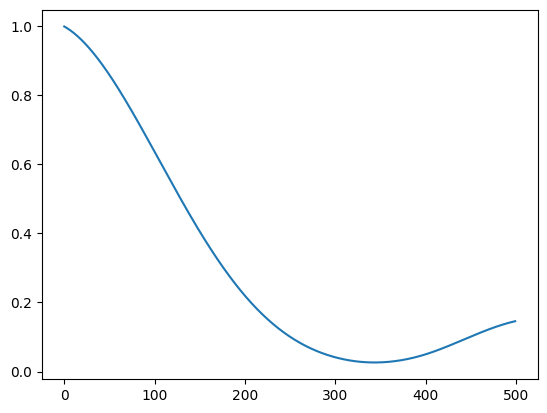

In [ ]:
# def calc_scores(layer_power, output, vx):
#     layer_power = layer_power - np.mean(layer_power, axis=1).reshape(-1, 1)
#     relative_power = compute_rel_power(layer_power, freqs)
#     smooth_power = csd_smooth(relative_power)
#     depth_s, freq_s = smooth_power.shape
    
#     ab_idx = np.where((freqs >= 7) & (freqs <= 30))[0]
#     g_idx = np.where((freqs >= 50) & (freqs <= 125))[0]

#     ab_pow = np.mean(smooth_power[:, ab_idx], axis=1)
#     g_pow = np.mean(smooth_power[:, g_idx], axis=1)
    
#     try:
#         crossover = get_crossover(freqs, smooth_power, smooth_power)
#     except:
#         crossover = 0
#     cr_score = crossover/depth_s    
#     y = np.linspace(0, 1, num=depth_s)
#     x = minmax_scale(ab_pow - g_pow)
#     ranges = [y < 0.33, (y >= 0.33) & (y < 0.66), y >= 0.66]
#     for r in ranges:
#         x[r] = np.mean(x[r])
#     x = minmax_scale(x)
#     balance_score = np.mean(x[ranges[0]]) - np.mean(x[ranges[2]])
#     output[(vx, "balance")] = balance_score
#     output[(vx, "crossover")] = cr_score

# output = {}

# Parallel(n_jobs=-1, require="sharedmem")(delayed(calc_scores)(data[:, vx, :], output, vx) for vx in range(vx_no))

In [306]:
balance_all = []
for vx in tqdm_notebook(range(vx_no)):
    layer_power = data[:, vx, :]
    layer_power = layer_power - np.median(layer_power, axis=1).reshape(-1, 1)
    relative_power = compute_rel_power(layer_power, freqs)
    depth_s, freq_s = relative_power.shape
    
    ab_idx = np.where((freqs >= 7) & (freqs <= 30))[0]
    g_idx = np.where((freqs >= 50) & (freqs <= 125))[0]

    ab_pow = np.mean(relative_power[:, ab_idx], axis=1)
    g_pow = np.mean(relative_power[:, g_idx], axis=1)
    
    y = np.linspace(0, 1, num=depth_s)
    x = minmax_scale(ab_pow - g_pow)
    ranges = [y < 0.33, (y >= 0.33) & (y < 0.66), y >= 0.66]
    for r in ranges:
        x[r] = np.mean(x[r])
    x = minmax_scale(x)
    balance_score = np.mean(x[ranges[0]]) - np.mean(x[ranges[2]])
    balance_all.append(balance_score)
balance_all = np.array(balance_all)

  0%|          | 0/32166 [00:00<?, ?it/s]

In [332]:
np.where((balance_all < 0.3) & (balance_all > -0.3))

(array([   12,    86,   132,   159,   204,   421,   510,   547,   716,
          847,   870,   911,   942,  1067,  1155,  1220,  1371,  1507,
         1731,  1835,  2052,  2225,  2229,  2259,  2267,  2277,  2371,
         2410,  2461,  2536,  2617,  2619,  2794,  2812,  2949,  3036,
         3090,  3149,  3171,  3222,  3224,  3261,  3293,  3326,  3327,
         3368,  3417,  3474,  3618,  3619,  3640,  3642,  3823,  3859,
         3866,  4040,  4204,  4227,  4267,  4334,  4353,  4501,  4552,
         4557,  4584,  4629,  4662,  4677,  4699,  4730,  4816,  4982,
         4998,  5017,  5060,  5143,  5156,  5218,  5248,  5258,  5270,
         5275,  5290,  5376,  5462,  5489,  5609,  5650,  5732,  5739,
         5747,  5831,  5918,  5971,  6021,  6113,  6123,  6144,  6421,
         6441,  6443,  6486,  6546,  6597,  6630,  6641,  6695,  6707,
         6781,  6801,  6811,  6852,  6880,  6923,  6929,  7044,  7125,
         7132,  7155,  7192,  7196,  7294,  7316,  7320,  7355,  7411,
      

In [349]:
pink = np.array([1.0, 0.41, 0.71])
green = np.array([0.71, 1.0, 0.41])
blue = np.array([0.41, 0.71, 1.0])
gray = np.array([0.5, 0.5, 0.5])
xcolours = np.repeat(gray.reshape(1,-1), vertices.shape[0], axis=0)
label_colours = [pink, blue, green]
b_ranges = [balance_all > 0.99, (balance_all <= 0.99) & (balance_all > -0.99), balance_all < -0.99]

for b_ix, b_r in enumerate(b_ranges):
    xcolours[b_r] = label_colours[b_ix]

brain = nb.load(info["pial_ds_nodeep_inflated"])
vertices, faces = brain.agg_data()
# brain = nb.load(info["pial_ds_nodeep"])
# vertices, faces, _ = brain.agg_data()

mesh = trimesh.Trimesh(vertices=vertices, faces=faces, process=False, validate=False)
mesh = mesh.as_open3d
mesh.compute_vertex_normals(normalized=True)

mesh.vertex_colors = o3d.utility.Vector3dVector(xcolours)
shapes = [mesh]
custom_draw_geometry(shapes, save=False)

print("1", np.round(np.mean(b_ranges[0])*100, 2), "%")
print("-1", np.round(np.mean(b_ranges[2])*100, 2), "%")
print("else", np.round(np.mean(b_ranges[1])*100, 2), "%")

1 63.94 %
-1 25.89 %
else 10.17 %


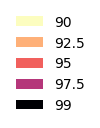

In [314]:
# METRIC VISUALISATION
power_metric = np.sum(np.mean(data, axis=0), axis=-1)
prc_range = [90, 92.5, 95, 97.5, 99]
cm = plt.colormaps["magma_r"]
col_val = np.linspace(0, 0.5,num=len(prc_range)-1)
col_val = np.append(col_val, 1)
label_colours = cm(col_val)[:,:3]

legend_items = []
for ix, lab in enumerate(prc_range):
    p = Patch(
        facecolor=label_colours[ix],
        label="{}".format(lab)
    )
    legend_items.append(p)
f, ax = plt.subplots(figsize=(1,1))
ax.legend(handles=legend_items, loc="center", frameon=False)
ax.axis("off");

# METRIC VISUALISATION
brain = nb.load(info["pial_ds_nodeep_inflated"])
vertices, faces = brain.agg_data()
mesh = trimesh.Trimesh(vertices=vertices, faces=faces, process=False, validate=False)
mesh = mesh.as_open3d
mesh.compute_vertex_normals(normalized=True)
gray = np.array([0.5, 0.5, 0.5])
colours = np.repeat(gray.reshape(1,-1), vertices.shape[0], axis=0)

for ix, pr in enumerate(prc_range):
    map_perc = power_metric >= np.percentile(power_metric, pr)
    colours[map_perc] = label_colours[ix]

mesh.vertex_colors = o3d.utility.Vector3dVector(colours)
shapes = [mesh]
custom_draw_geometry(shapes, save=False)

In [346]:
modified_cols = deepcopy(xcolours)
# modified_cols[power_metric < np.percentile(power_metric, 99)] = gray

brain = nb.load(info["pial_ds_nodeep_inflated"])
vertices, faces = brain.agg_data()
mesh = trimesh.Trimesh(vertices=vertices, faces=faces, process=False, validate=False)
mesh = mesh.as_open3d
mesh.compute_vertex_normals(normalized=True)

mesh.vertex_colors = o3d.utility.Vector3dVector(modified_cols)
shapes = [mesh]
custom_draw_geometry(shapes, save=False)

In [361]:
balance_GGG = []
for vx in tqdm_notebook(range(vx_no)):
    sp_unfet = compute_rel_power(data[:, vx, :], freqs)
    avg_ff = np.mean(sp_unfet, axis=1)
    balance_score = avg_ff[0] - avg_ff[-1]
    balance_GGG.append(balance_score)
balance_GGG = np.array(balance_GGG)

  0%|          | 0/32166 [00:00<?, ?it/s]

In [363]:
pink = np.array([1.0, 0.41, 0.71])
green = np.array([0.71, 1.0, 0.41])
blue = np.array([0.41, 0.71, 1.0])
gray = np.array([0.5, 0.5, 0.5])
cxcolours = np.repeat(gray.reshape(1,-1), vertices.shape[0], axis=0)
label_colours = [pink, blue, green]
b_rangesc = [balance_GGG > 0.5, (balance_GGG <= 0.5) & (balance_GGG > -0.5), balance_GGG < -0.5]

for b_ix, b_r in enumerate(b_rangesc):
    cxcolours[b_r] = label_colours[b_ix]

# brain = nb.load(info["pial_ds_nodeep_inflated"])
# vertices, faces = brain.agg_data()
brain = nb.load(info["pial_ds_nodeep"])
vertices, faces, _ = brain.agg_data()

mesh = trimesh.Trimesh(vertices=vertices, faces=faces, process=False, validate=False)
mesh = mesh.as_open3d
mesh.compute_vertex_normals(normalized=True)

mesh.vertex_colors = o3d.utility.Vector3dVector(cxcolours)
shapes = [mesh]
custom_draw_geometry(shapes, save=False)

print("1", np.round(np.mean(b_ranges[0])*100, 2), "%")
print("-1", np.round(np.mean(b_ranges[2])*100, 2), "%")
print("else", np.round(np.mean(b_ranges[1])*100, 2), "%")

1 63.94 %
-1 25.89 %
else 10.17 %
